In [1]:
import sys
import os
import glob
import session_info
import warnings

import matplotlib as mpl

import re

import seaborn as sns

from pyprojroot.here import here

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = '#FFFFFF'

import pandas as pd
import numpy as np
import scanpy as sc

from PyComplexHeatmap import *

from sklearn.metrics import balanced_accuracy_score, f1_score

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

from customPalette import diseases_palette, diseaseCategories, diseasesGroup_palette

dpi_fig_save = 300

### Loading dataframes with labels

In [2]:
corrData = pd.read_pickle(here('03_downstream_analysis/08_gene_importance/results/xgboost_aggregated_predictions.pkl'))
unCorrData = pd.read_pickle(here('03_downstream_analysis/08_gene_importance/results/xgboost_unintegrated_aggregated_predictions.pkl'))

In [3]:
corrData = corrData.rename({'y_true':'disease', 'y_pred':'disease_pred','cell_type':'Level1'}, axis=1)
unCorrData = unCorrData.rename({'y_true':'disease', 'y_pred':'disease_pred','cell_type':'Level1'}, axis=1)

In [4]:
corrData['disease_cat'] = corrData.disease.map(diseaseCategories)

In [5]:
unCorrData['disease_cat'] = unCorrData.disease.map(diseaseCategories)

**Overall BAS and Weighted F1:**

*scANVI corrected expression profiles*

In [6]:
print(f"BAS scANVI corrected data: {balanced_accuracy_score(y_true = corrData.disease, y_pred=corrData.disease_pred)}")
print(f"W_F1 scANVI corrected data: {f1_score(y_true = corrData.disease, y_pred=corrData.disease_pred, average='weighted')}")

BAS scANVI corrected data: 0.8730505418612455
W_F1 scANVI corrected data: 0.9015464215480049


*non-corrected expression profiles*

In [7]:
print(f"BAS Log-scaled data: {balanced_accuracy_score(y_true = unCorrData.disease, y_pred=unCorrData.disease_pred)}")
print(f"BAS Log-scaled data: {f1_score(y_true = unCorrData.disease, y_pred=unCorrData.disease_pred, average='weighted')}")

BAS Log-scaled data: 0.6479029457730977
BAS Log-scaled data: 0.7837386956410798


**BAS for each cell-type**

In [16]:
corrData.groupby(['Level1'])[['disease','disease_pred']].apply(lambda x: (balanced_accuracy_score(y_true = x.disease.astype(str),
                                                                                                       y_pred = x.disease_pred.astype(str))))

Level1
B                 0.873774
DC                0.857148
ILC               0.856527
Mono              0.895080
Plasma            0.777135
T_CD4_Naive       0.863004
T_CD4_NonNaive    0.885057
T_CD8_Naive       0.864763
T_CD8_NonNaive    0.855454
UTC               0.790900
pDC               0.746769
dtype: float64

**Weighted F1, for each cell-type**

In [17]:
corrData.groupby(['Level1'])[['disease','disease_pred']].apply(lambda x: (f1_score(y_true = x.disease.astype(str),
                                                                                   y_pred = x.disease_pred.astype(str),
                                                                                   average='weighted')))

Level1
B                 0.878075
DC                0.904717
ILC               0.875045
Mono              0.923040
Plasma            0.803823
T_CD4_Naive       0.894848
T_CD4_NonNaive    0.917895
T_CD8_Naive       0.912580
T_CD8_NonNaive    0.881929
UTC               0.901246
pDC               0.914586
dtype: float64

In [ ]:
corrData.groupby('Level1').

In [8]:
print(f"BAS scANVI corrected data: {balanced_accuracy_score(y_true = corrData.query("Level1 == 'Plasma'").disease, y_pred=corrData.query("Level1 == 'Plasma'").disease_pred)}")
print(f"W_F1 scANVI corrected data: {f1_score(y_true = corrData.query("Level1 == 'Plasma'").disease, y_pred=corrData.query("Level1 == 'Plasma'").disease_pred, average='weighted')}")

BAS scANVI corrected data: 0.7771354050164407
W_F1 scANVI corrected data: 0.8038232556633812


## Confusion matrix visualization

#### Functions

In [55]:
# Computing the confusion matrix
def getConfusionMatrix(predTestDF = None, predCol = 'y_pred', gtCol = 'y_test', normalize='columns'):

    # normalize could be False, 'rows', or 'columns' (default).
    
    import pandas as pd

    if normalize == False:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], dropna=False)
    else:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], normalize=normalize, dropna=False)

    if confusionMatrix.shape[0] < confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.columns.tolist(), confusionMatrix.index.tolist()):
            confusionMatrix.loc[d,:] = 0
    elif confusionMatrix.shape[0] > confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.index.tolist(),confusionMatrix.columns.tolist()):
            confusionMatrix[d] = 0   

    return(confusionMatrix)

In [56]:
def reorder_ConfMatrix(confusionMatrix=None, elementList = None):

    confusionMatrix = confusionMatrix.reindex(elementList, axis=0).reindex(elementList, axis=1)

    return(confusionMatrix)

In [57]:
def mask_entries(confusionMatrix=None, lowerThan = 0, cmap='viridis'):
    confusionMatrix_nan = confusionMatrix.copy()
    confusionMatrix_nan[confusionMatrix_nan <= lowerThan] = np.nan
    return(confusionMatrix_nan)
    

#### Changing the PyComplexHeatmap code

https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html#Composite-two-heatmaps-horizontally-for-mouse-DNA-methylation-array-dataset

The following change is required to avoid reordering columns and rows. So, disease in the same category are close to each others

In [58]:
def _reorder_rows(self):
    self.row_split_dendrogram = False
    if self.verbose >= 1:
        print("Reordering rows..")
    if self.row_split is None and self.row_cluster:
        self.calculate_row_dendrograms(
            self.data2d
        )  # xind=self.dendrogram_row.reordered_ind
        self.row_order = [
            self.dendrogram_row.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.row_split, int) and self.row_cluster:
        self.calculate_row_dendrograms(self.data2d)
        self.row_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_row.linkage,
                    t=self.row_split,
                    criterion="maxclust",
                ),
                index=self.data2d.index.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_row.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.row_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.row_split, pd.Series):
            self.row_split = self.row_split.to_frame(name=self.row_split.name)
        cols = self.row_split.columns.tolist()
        row_clusters = self.row_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.row_split_order is None:
            self.row_split_order = row_clusters.index.tolist()
        elif self.row_split_order == 'cluster_between_groups':
            mat=pd.concat([
                self.data2d.loc[rows].mean() for rows in row_clusters.tolist()],
                          axis=1).T #columns are original columns
            mat.index=row_clusters.index.tolist()
            sizes=row_clusters.apply(lambda x:len(x)).tolist()
            self.calculate_row_dendrograms(mat,sizes=sizes)
            self.row_split_order = self.dendrogram_row.dendrogram["ivl"]
            self.row_split_dendrogram=self.dendrogram_row
        self.row_clusters = row_clusters.loc[self.row_split_order].to_dict()
    elif not self.row_cluster:
        self.row_order = [self.data2d.index.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.row_order = []
    self.dendrogram_rows = []
    for i, cluster in enumerate(self.row_clusters):
        rows = self.row_clusters[cluster]
        if len(rows) <= 1:
            self.row_order.append(rows)
            self.dendrogram_rows.append(None)
            continue
        if self.row_cluster: #cluster within groups
            self.calculate_row_dendrograms(self.data2d.loc[rows])
            self.dendrogram_rows.append(self.dendrogram_row)
            self.row_order.append(self.dendrogram_row.dendrogram["ivl"])
        else:
            self.row_order.append(rows)

def _reorder_cols(self):
    self.col_split_dendrogram=False
    if self.verbose >= 1:
        print("Reordering cols..")
    if self.col_split is None and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_order = [
            self.dendrogram_col.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.col_split, int) and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_col.linkage,
                    t=self.col_split,
                    criterion="maxclust",
                ),
                index=self.data2d.columns.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_col.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.col_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.col_split, pd.Series):
            self.col_split = self.col_split.to_frame(name=self.col_split.name)
        cols = self.col_split.columns.tolist()
        col_clusters = self.col_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.col_split_order is None:
            self.col_split_order = col_clusters.index.tolist()
        elif self.col_split_order == 'cluster_between_groups':
            mat = pd.concat([
                self.data2d.loc[:,cols].mean(axis=1) for cols in col_clusters.tolist()],
                axis=1)  # index are original rows labels
            mat.columns = col_clusters.index.tolist()
            sizes = col_clusters.apply(lambda x: len(x)).tolist()
            self.calculate_col_dendrograms(mat, sizes=sizes)
            self.col_split_order = self.dendrogram_col.dendrogram["ivl"]
            self.col_split_dendrogram = self.dendrogram_col
        self.col_clusters = col_clusters.loc[self.col_split_order].to_dict()
    elif not self.col_cluster:
        self.col_order = [self.data2d.columns.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.col_order = []
    self.dendrogram_cols = []
    for i, cluster in enumerate(self.col_clusters):
        cols = self.col_clusters[cluster]
        if len(cols) <= 1:
            self.col_order.append(cols)
            self.dendrogram_cols.append(None)
            continue
        if self.col_cluster:
            self.calculate_col_dendrograms(self.data2d.loc[:, cols])
            self.dendrogram_cols.append(self.dendrogram_col)
            self.col_order.append(self.dendrogram_col.dendrogram["ivl"])
        else:
            self.col_order.append(cols)

def plot_matrix(self, row_order, col_order):
    col_order=row_order.copy()
    if self.verbose >= 1:
        print("Plotting matrix..")
    nrows = len(row_order)
    ncols = len(col_order)
    self.wspace = (
        self.col_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().width / ncols)
    )  # 1mm=mm2inch inch
    self.hspace = (
        self.row_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().height / nrows)
    )  # height
    self.heatmap_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        nrows,
        ncols,
        hspace=self.hspace,
        wspace=self.wspace,
        subplot_spec=self.gs[1, 1],
        height_ratios=[len(rows) for rows in row_order],
        width_ratios=[len(cols) for cols in col_order],
    )

    annot = self.kwargs.pop("annot", None)
    if annot is None or annot is False:
        pass
    else:
        if isinstance(annot, bool):
            annot_data = self.data2d
        else:
            annot_data = annot.copy()
            if annot_data.shape != self.data2d.shape:
                err = "`data` and `annot` must have same shape."
                raise ValueError(err)

    self.heatmap_axes = np.empty(shape=(nrows, ncols), dtype=object)
    # if nrows > 1 or ncols > 1:
    self.ax_heatmap.set_axis_off()
    for i, rows in enumerate(row_order):
        for j, cols in enumerate(col_order):
            # print(i,j)
            ax1 = self.ax_heatmap.figure.add_subplot(
                self.heatmap_gs[i, j],
                sharex=self.heatmap_axes[0, j],
                sharey=self.heatmap_axes[i, 0],
            )
            ax1.set_xlim([0, len(rows)])
            ax1.set_ylim([0, len(cols)])
            annot1 = None if annot is None else annot_data.loc[rows, cols]
            # heatmap(self.data2d.loc[rows, cols], ax=ax1, cbar=False, cmap=self.cmap,
            #         cbar_kws=None, mask=self.mask.loc[rows, cols], rasterized=self.rasterized,
            #         xticklabels='auto', yticklabels='auto', annot=annot1, **self.kwargs)
            plot_heatmap(
                self.data2d.loc[rows, cols],
                ax=ax1,
                cmap=self.cmap,
                mask=self.mask.loc[rows, cols],
                rasterized=self.rasterized,
                xticklabels="auto",
                yticklabels="auto",
                annot=annot1,
                **self.kwargs
            )
            self.heatmap_axes[i, j] = ax1
            ax1.yaxis.label.set_visible(False)
            ax1.xaxis.label.set_visible(False)
            ax1.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelright=False,
                top=False,
                bottom=False,
                labeltop=False,
                labelbottom=False,
            )


In [59]:
ClusterMapPlotter._reorder_rows = _reorder_rows
ClusterMapPlotter._reorder_cols = _reorder_cols
# ClusterMapPlotter.plot_matrix = plot_matrix

## Overall confusion matrix
Heatmap with accuracy score considering all cell-types and all datasets

In [60]:
elementList = ['healthy'] + [d for d in corrData[['disease','disease_cat']].drop_duplicates().sort_values(['disease_cat','disease']).disease.tolist() if d != 'healthy']
diseaseCatOrd =  ['healthy'] + [d for d in corrData[['disease','disease_cat']].drop_duplicates().sort_values(['disease_cat','disease']).disease_cat.tolist() if d != 'healthy']

In [61]:
rowAnnDF = corrData[['disease','disease_cat']].drop_duplicates().reset_index().set_index('disease')

row_ann = HeatmapAnnotation(disease_group=anno_simple(rowAnnDF.disease_cat,colors=diseasesGroup_palette,rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=0,verbose=0, label_kws={'text':None}, plot=False, legend=True)

### SCANVI integrated and batch-corrected data

In [68]:
Overall_confusionMatrix = getConfusionMatrix(predTestDF= corrData, predCol = 'disease_pred', gtCol = 'disease')
Overall_confusionMatrix_ord = reorder_ConfMatrix(mask_entries(Overall_confusionMatrix, lowerThan = -1), elementList=elementList)

In [69]:
Overall_confusionMatrix_ord.loc['flu','flu']

0.03478533375117518

In [78]:
Overall_confusionMatrix_ord.loc[:,'flu']

disease_pred
healthy      0.068944
CD           0.000000
MS           0.000000
PS           0.000000
PSA          0.000000
RA           0.000000
SLE          0.000000
UC           0.000000
sepsis       0.148856
COPD         0.000000
asthma       0.000000
cirrhosis    0.000000
COVID        0.747415
HBV          0.000000
HIV          0.000000
flu          0.034785
BRCA         0.000000
CRC          0.000000
HNSCC        0.000000
NPC          0.000000
Name: flu, dtype: float64

In [70]:
Overall_confusionMatrix_ord.loc['sepsis','sepsis']

0.6353879516300952

In [71]:
Overall_confusionMatrix_ord.loc['HIV','HIV']

0.6251448435689455

In [76]:
corrData.disease.value_counts()

disease
healthy      330930
COVID        121860
SLE          115613
RA            34427
sepsis        27207
PS            22444
cirrhosis     21316
PSA           21286
UC            19009
NPC           18896
CD            17916
HBV           17678
CRC           16911
COPD          12998
asthma        12098
BRCA           7596
HNSCC          7217
HIV            5178
MS             5142
flu            3191
Name: count, dtype: int64

In [77]:
corrData.disease.value_counts(normalize=True)

disease
healthy      0.394475
COVID        0.145259
SLE          0.137813
RA           0.041038
sepsis       0.032431
PS           0.026754
cirrhosis    0.025409
PSA          0.025373
UC           0.022659
NPC          0.022524
CD           0.021356
HBV          0.021073
CRC          0.020158
COPD         0.015494
asthma       0.014421
BRCA         0.009055
HNSCC        0.008603
HIV          0.006172
MS           0.006129
flu          0.003804
Name: proportion, dtype: float64

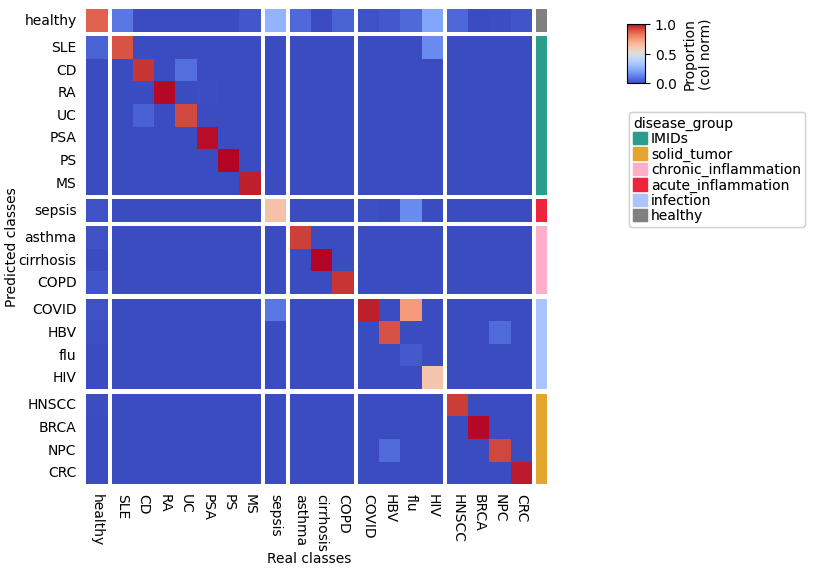

In [17]:
plt.figure(figsize=(6,5.5))
cm = ClusterMapPlotter(data=Overall_confusionMatrix_ord, 
                       right_annotation=row_ann, 
                       # top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                       col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'Real classes', ylabel = 'Predicted classes',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1, legend=True, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)  
plt.savefig(here("03_downstream_analysis/08_gene_importance/results/overallConfusionMatrix_scANVIcorr.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [18]:
cellTypeList = list(np.sort(corrData.Level1.unique()))
cellTypeList

['B',
 'DC',
 'ILC',
 'Mono',
 'Plasma',
 'T_CD4_Naive',
 'T_CD4_NonNaive',
 'T_CD8_Naive',
 'T_CD8_NonNaive',
 'UTC',
 'pDC']

### Generating the heatmaps

B
DC
ILC
Mono
Plasma
T_CD4_Naive
T_CD4_NonNaive
T_CD8_Naive
T_CD8_NonNaive
UTC
pDC
Plotting ...
Estimated legend width: 48.861111111111114 mm


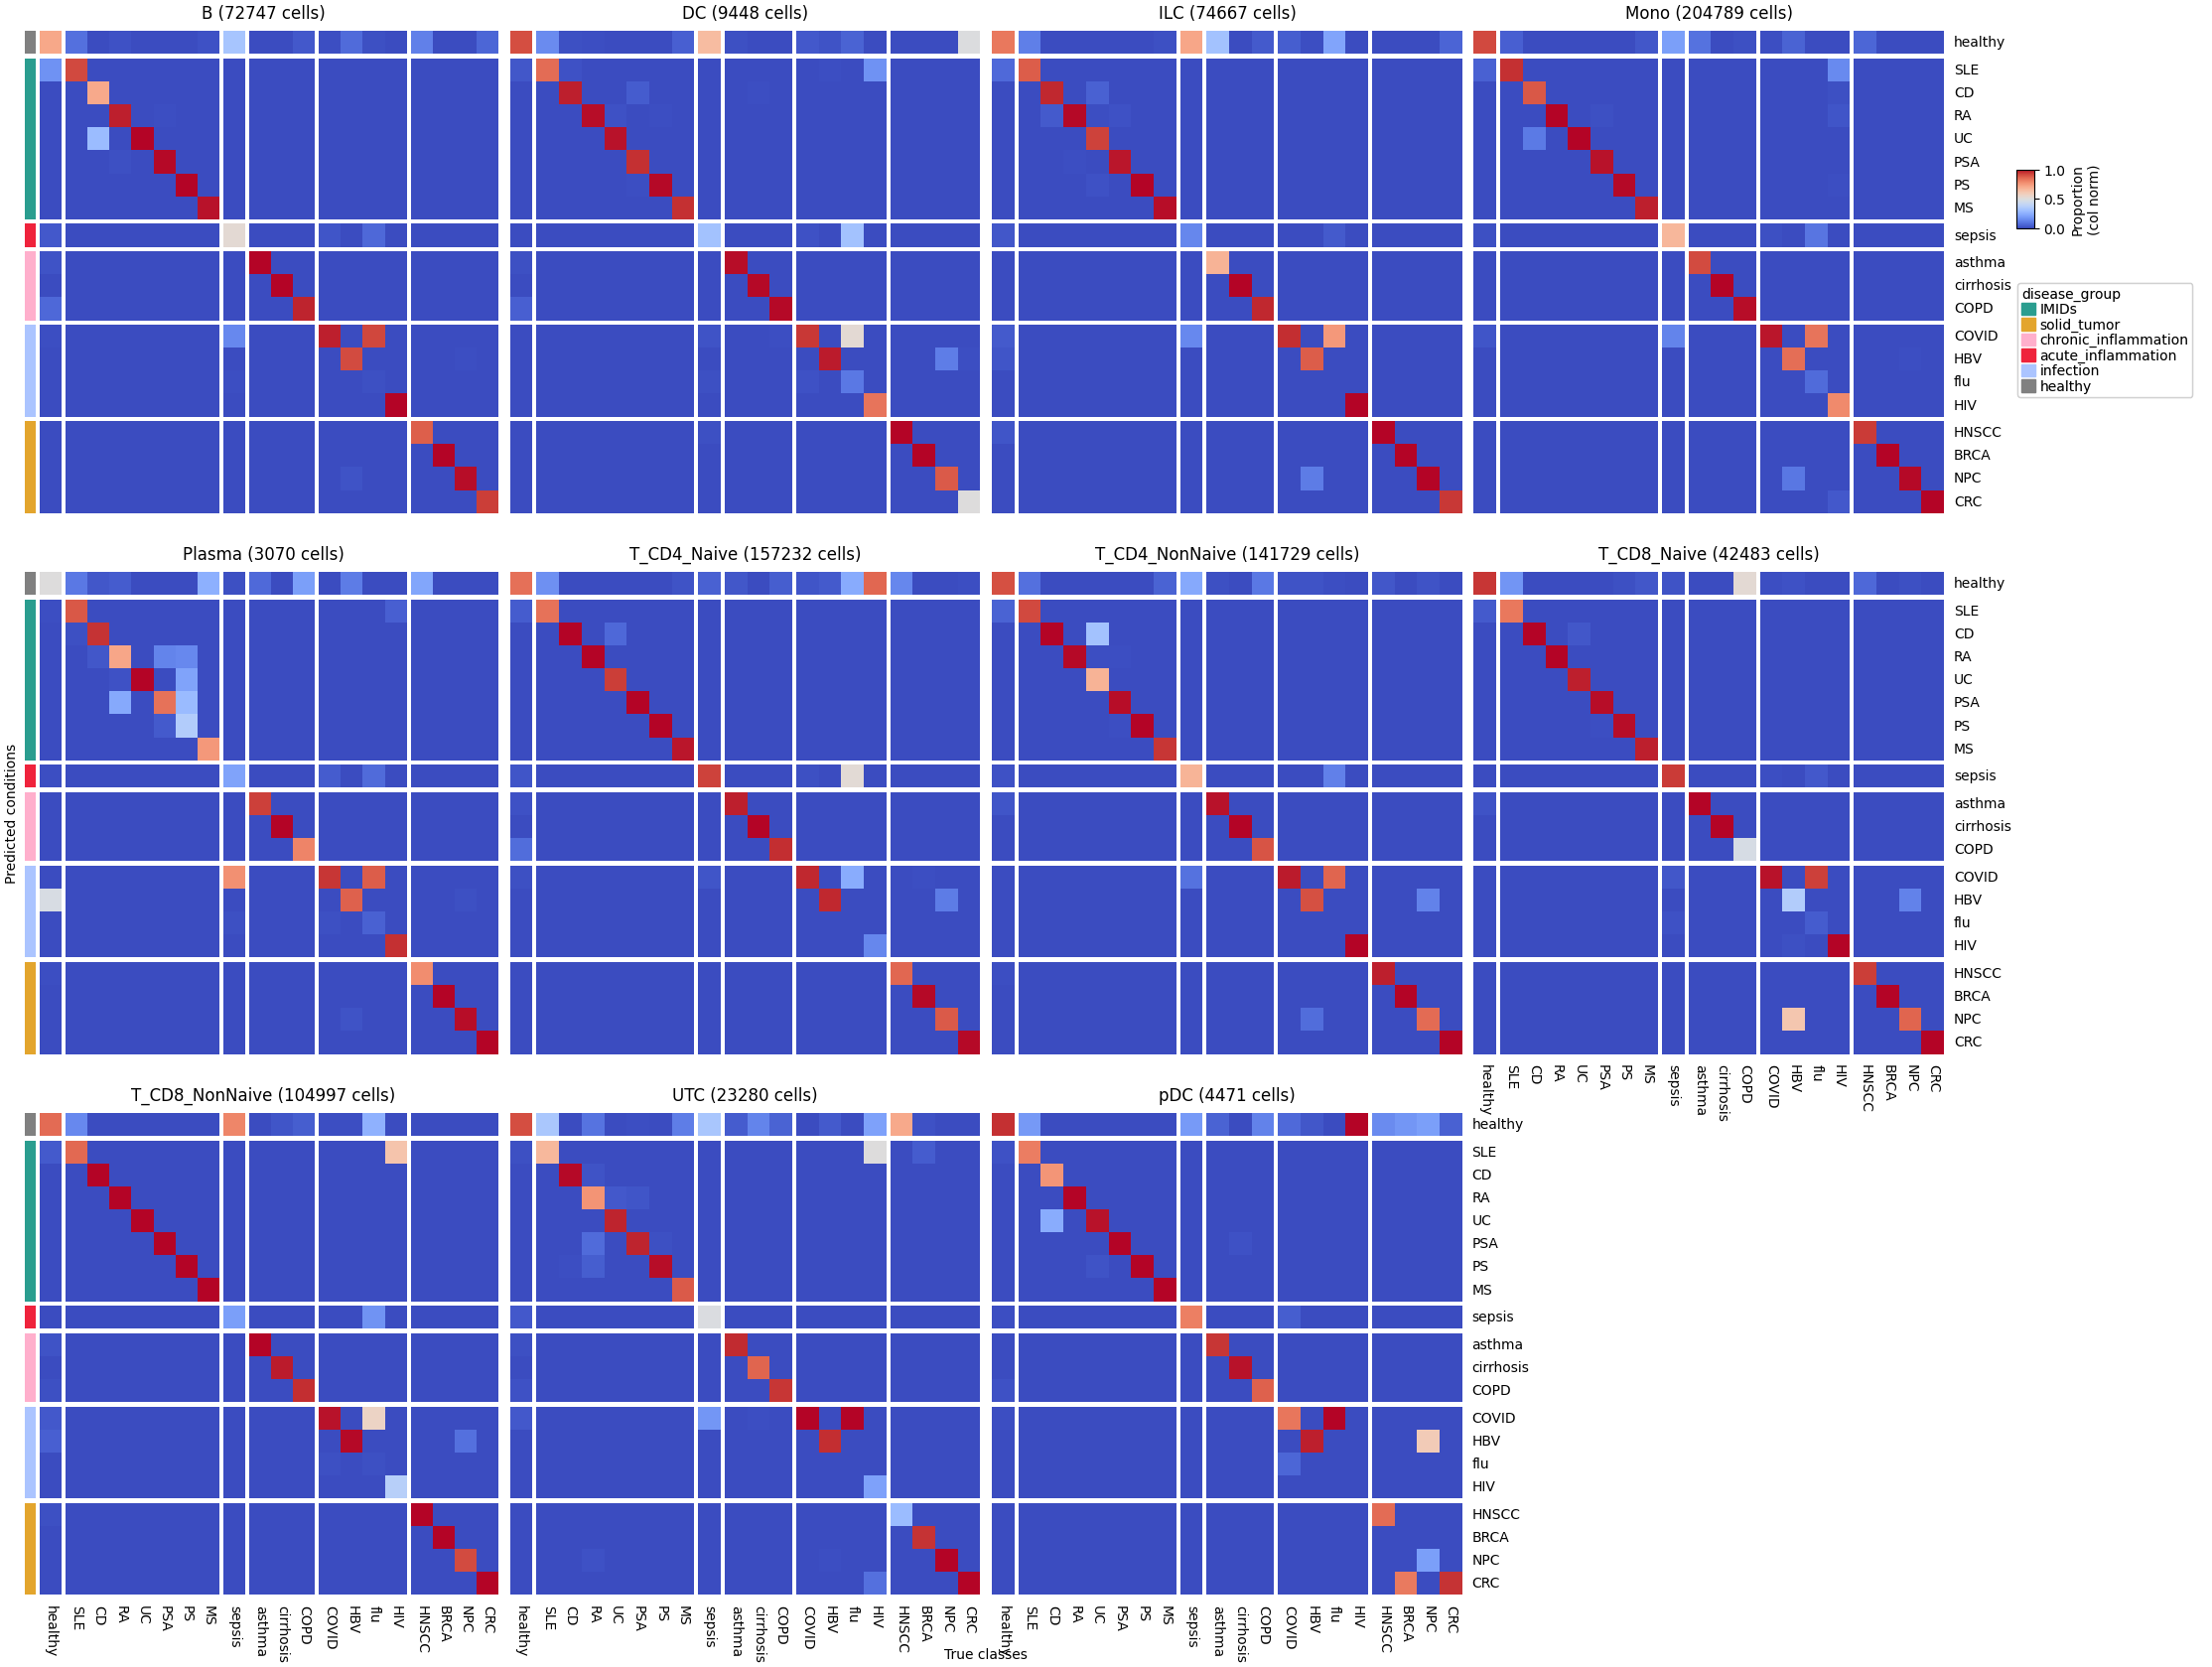

In [29]:
nCol = 4 #max(np.ceil((len(cellTypeList)+1) / 2).astype(int),1)
nRow = len(cellTypeList) // nCol + (len(cellTypeList) % nCol > 0)

wholeCM = list()
wholeCT = list()
confusionMatrixXct = dict()
for r in range(nRow):
    rowCM = list()
    rowCT = list()
    for c in range(nCol):

        idx = ((nCol*r) + c)

        if idx >= len(cellTypeList):
            continue
        
        ct_i = cellTypeList[idx]

        print(ct_i)
        
        idxCellType = corrData.Level1==ct_i
        confusionMatrix_i = getConfusionMatrix(predTestDF= corrData.loc[idxCellType,:],  predCol = 'disease_pred', gtCol = 'disease')
        confusionMatrix_i.fillna(0, inplace=True)
        confusionMatrix_i_ord = reorder_ConfMatrix(mask_entries(confusionMatrix_i, lowerThan = -1), elementList=elementList)
        
        totCell = np.sum(idxCellType)

        ################# Annotations

        ################# 

        showRownames = False
        if (c == (nCol-1)) | (((nCol*r) + c+1) >= len(cellTypeList)):
            showRownames = True

        showColnames = False
        if (r == (nRow-1)) | (((nCol*(r+1)) + c) >= len(cellTypeList)):
            showColnames = True

        leftAnnotation = None
        if (c == 0):
            leftAnnotation = row_ann

        confusionMatrixXct[ct_i] = confusionMatrix_i_ord
        cm_i = ClusterMapPlotter(data=confusionMatrix_i_ord, 
                                 left_annotation=leftAnnotation, 
                                 # top_annotation=col_ann, 
                                 row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                                 col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                                 show_rownames=showRownames,show_colnames=showColnames, 
                                 plot=False, fmt=None,
                                 row_cluster=False, col_cluster=False, standard_scale = None,
                                 row_dendrogram=False,col_dendrogram=False, verbose=False, cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1,
                                legend=True, label = 'Proportion\n(col norm)',legend_anchor='ax_heatmap',legend_vpad=5,
                                vmax = 1, vmin = 0)            

        rowCM.append(cm_i)
        rowCT.append('{} ({} cells)'.format(ct_i, totCell))
    wholeCM.append(rowCM)
    wholeCT.append(rowCT)
            

print('Plotting ...')

mm2inch = 1 / 25.4

row_gap = 12
col_gap = 12

nR = len(wholeCM)
nC = len(wholeCM[0])

plt.figure(figsize=(25,18))

ax = plt.gca()

wspace = mm2inch * ax.figure.dpi / (ax.get_window_extent().width / nC)
hspace = row_gap * mm2inch * ax.figure.dpi / (ax.get_window_extent().height / nR)


gs = ax.figure.add_gridspec(
    nR,
    nC,
    width_ratios=[1 for i in range(nC)],
    height_ratios=[1 for i in range(nR)],
    wspace=wspace,
    hspace=hspace,
)

for r in range(nR):
    for c in range(nC):

        idx = ((nCol*r) + c)
        
        if idx >= len(cellTypeList):
            continue
        
        ax1 = ax.figure.add_subplot(gs[r,c], sharex=None, sharey=None)
        wholeCM[r][c].plot(ax =ax1, subplot_spec=gs[r,c])
        wholeCM[r][c].ax.set_title(wholeCT[r][c])

        if (r==0) and (c==0):
            label_max_width = ax.figure.get_window_extent().width * wholeCM[r][c].label_max_width / wholeCM[r][c].ax.figure.get_window_extent().width
            legend_list = wholeCM[r][c].legend_list
        
        ax1.set_axis_off()
        
space = col_gap * mm2inch * ax.figure.dpi + label_max_width + 15
plot_legend_list(legend_list, ax=ax, space=space, legend_side='right', gap=15, y0=0.8, legend_width=None)

ax.set_ylabel('Predicted conditions')
ax.set_xlabel('True classes', labelpad = 35)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(here("03_downstream_analysis/08_gene_importance/results/confusionMatrix_cellTypes_scANVIcorrected.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

### Unintegrated uncorrected data (log-scaled)

In [65]:
Overall_confusionMatrix = getConfusionMatrix(predTestDF= unCorrData, predCol = 'disease_pred', gtCol = 'disease')
Overall_confusionMatrix_ord_unCorrData = reorder_ConfMatrix(mask_entries(Overall_confusionMatrix, lowerThan = -1), elementList=elementList)

In [67]:
Overall_confusionMatrix_ord_unCorrData.loc['flu','flu']

0.12190535882168599

In [72]:
Overall_confusionMatrix_ord_unCorrData.loc['sepsis','sepsis']

0.5288712463704194

In [73]:
Overall_confusionMatrix_ord_unCorrData.loc['HIV','HIV']

0.5525299343375821

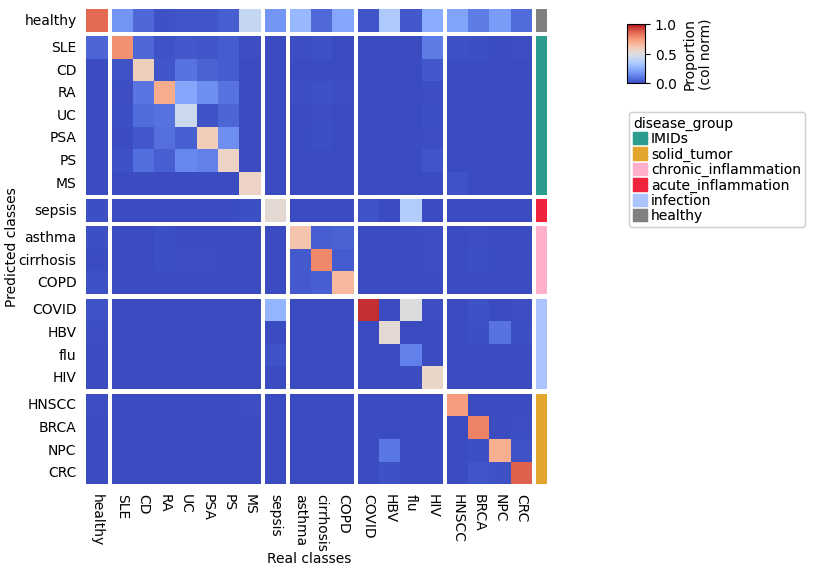

In [22]:
plt.figure(figsize=(6,5.5))
cm = ClusterMapPlotter(data=Overall_confusionMatrix_ord_unCorrData, 
                       right_annotation=row_ann, 
                       # top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                       col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'Real classes', ylabel = 'Predicted classes',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1, legend=True, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)  
plt.savefig(here("03_downstream_analysis/08_gene_importance/results/overallConfusionMatrix_NONcorrected.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [23]:
cellTypeList = list(np.sort(unCorrData.Level1.unique()))
cellTypeList

['B',
 'DC',
 'ILC',
 'Mono',
 'Plasma',
 'T_CD4_Naive',
 'T_CD4_NonNaive',
 'T_CD8_Naive',
 'T_CD8_NonNaive',
 'UTC',
 'pDC']

### Generating the heatmaps

B
DC
ILC
Mono
Plasma
T_CD4_Naive
T_CD4_NonNaive
T_CD8_Naive
T_CD8_NonNaive
UTC
pDC
Plotting ...
Estimated legend width: 48.861111111111114 mm


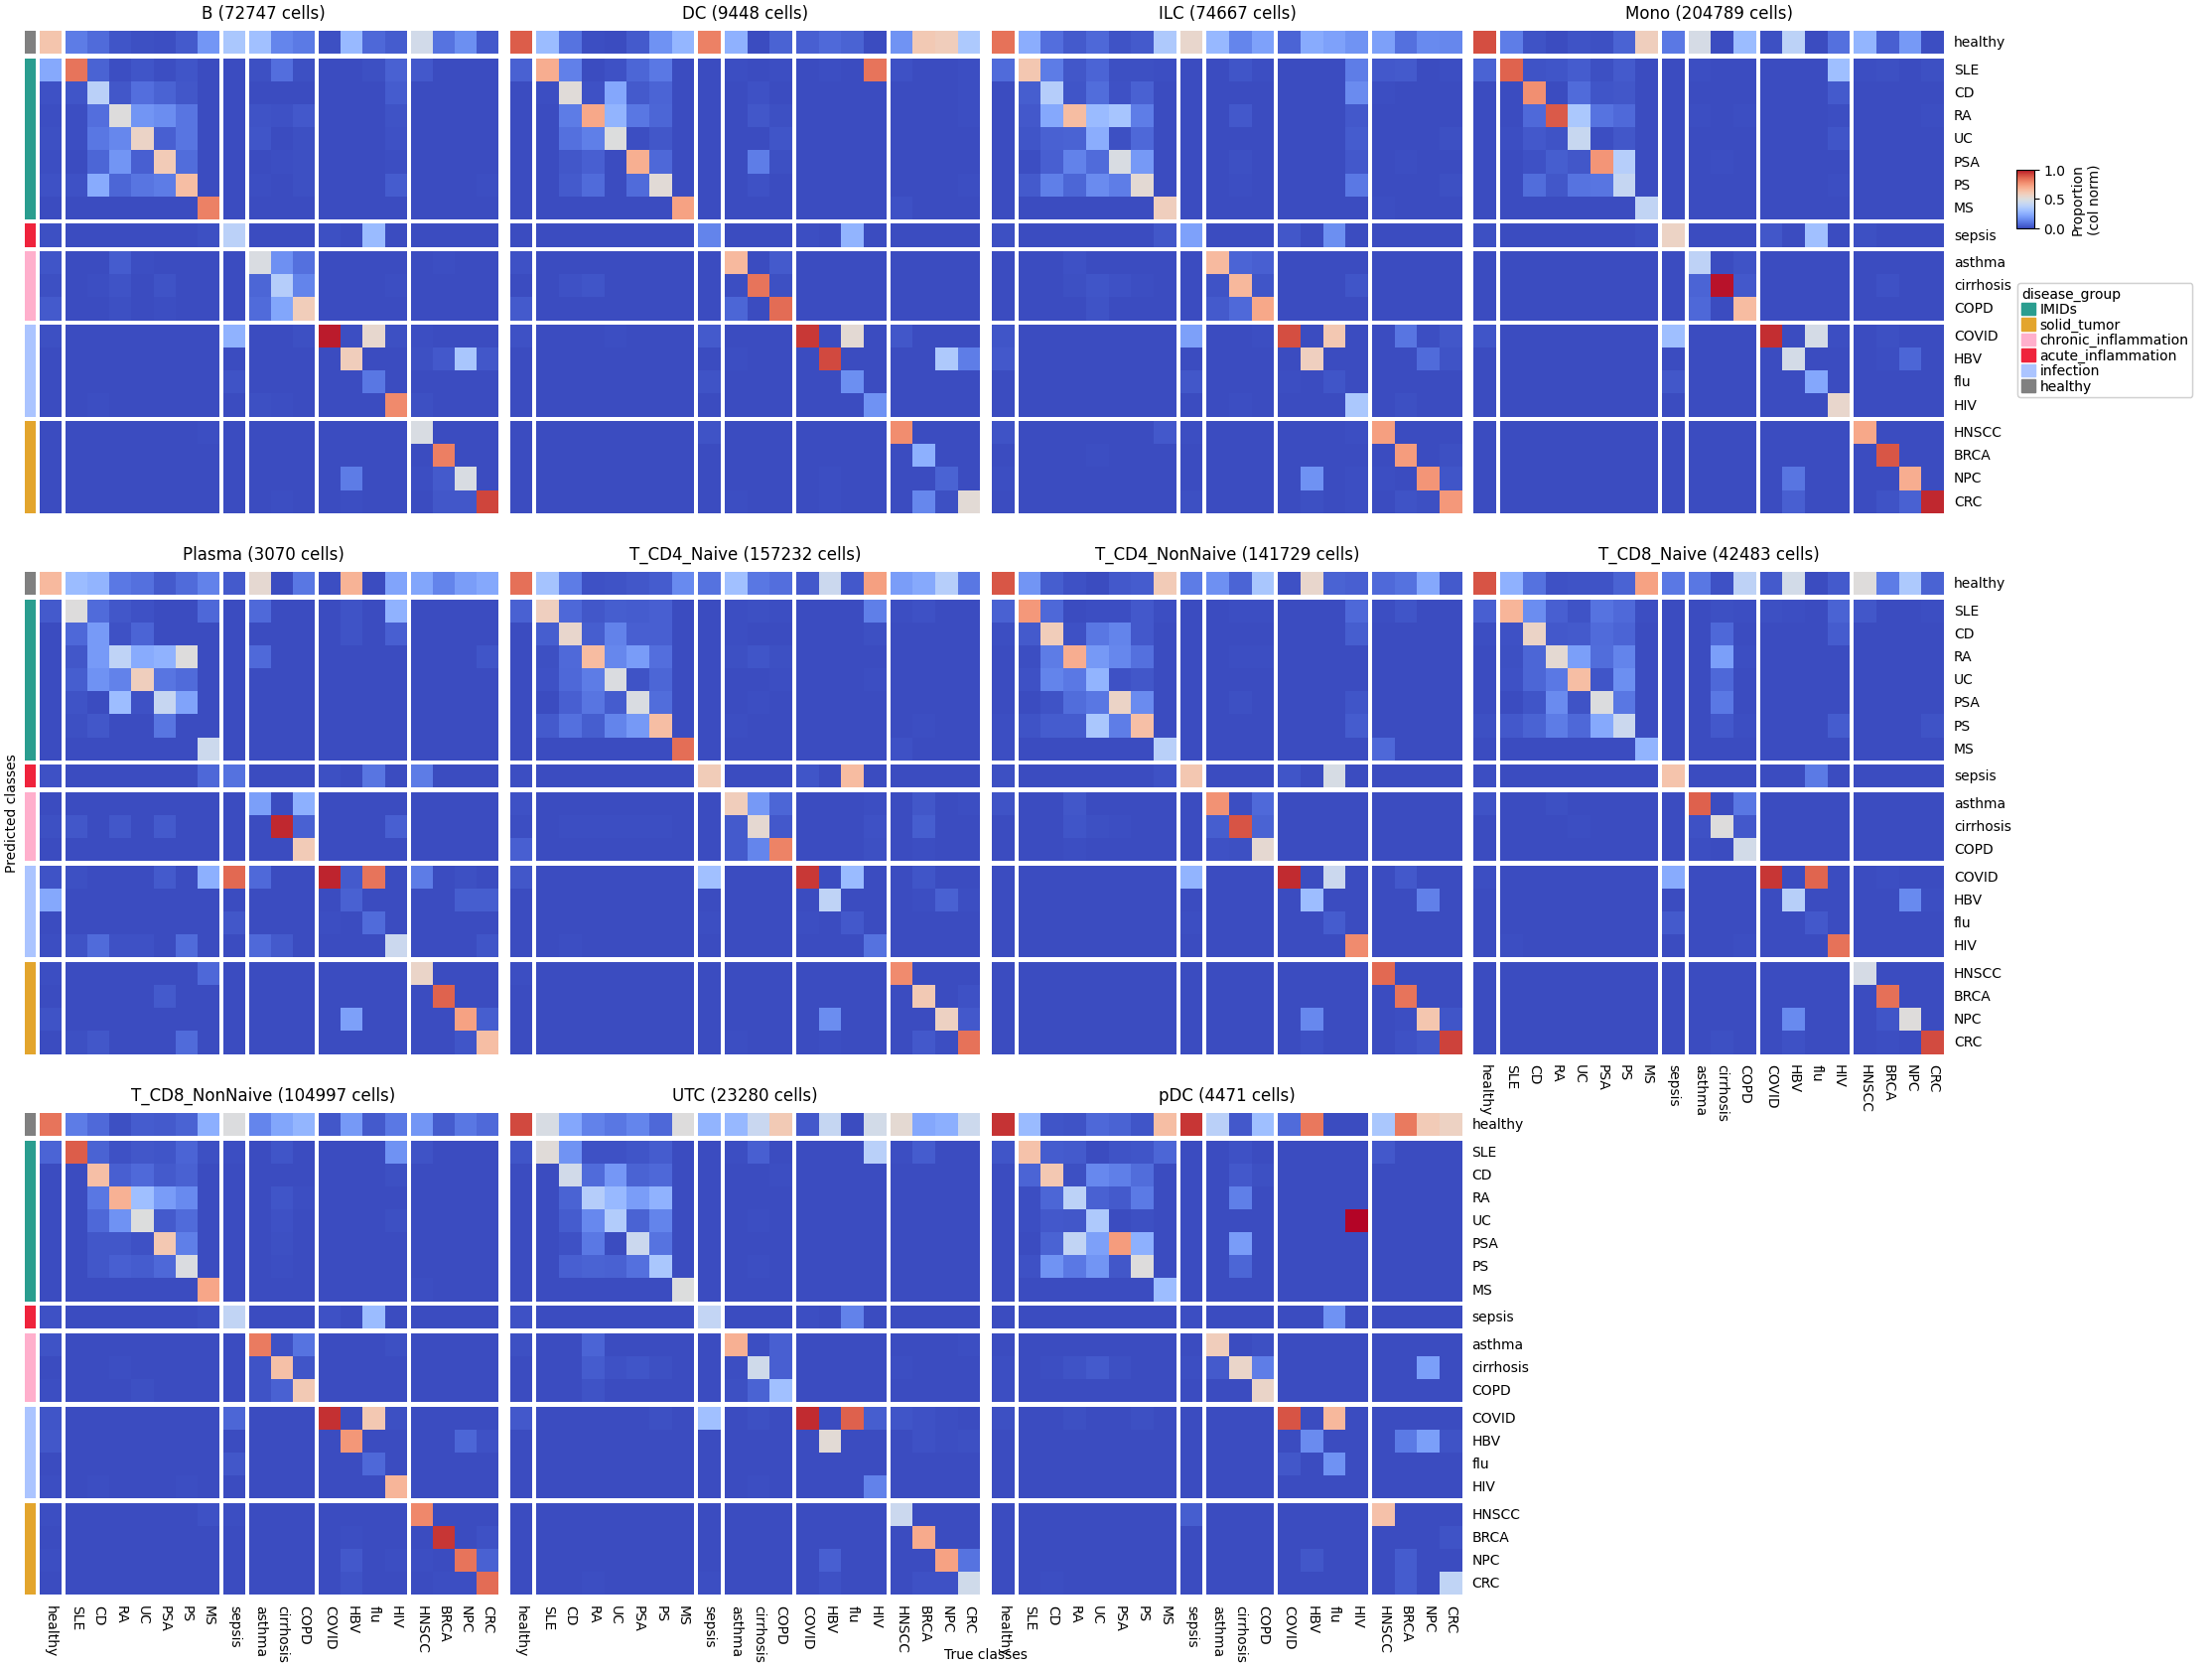

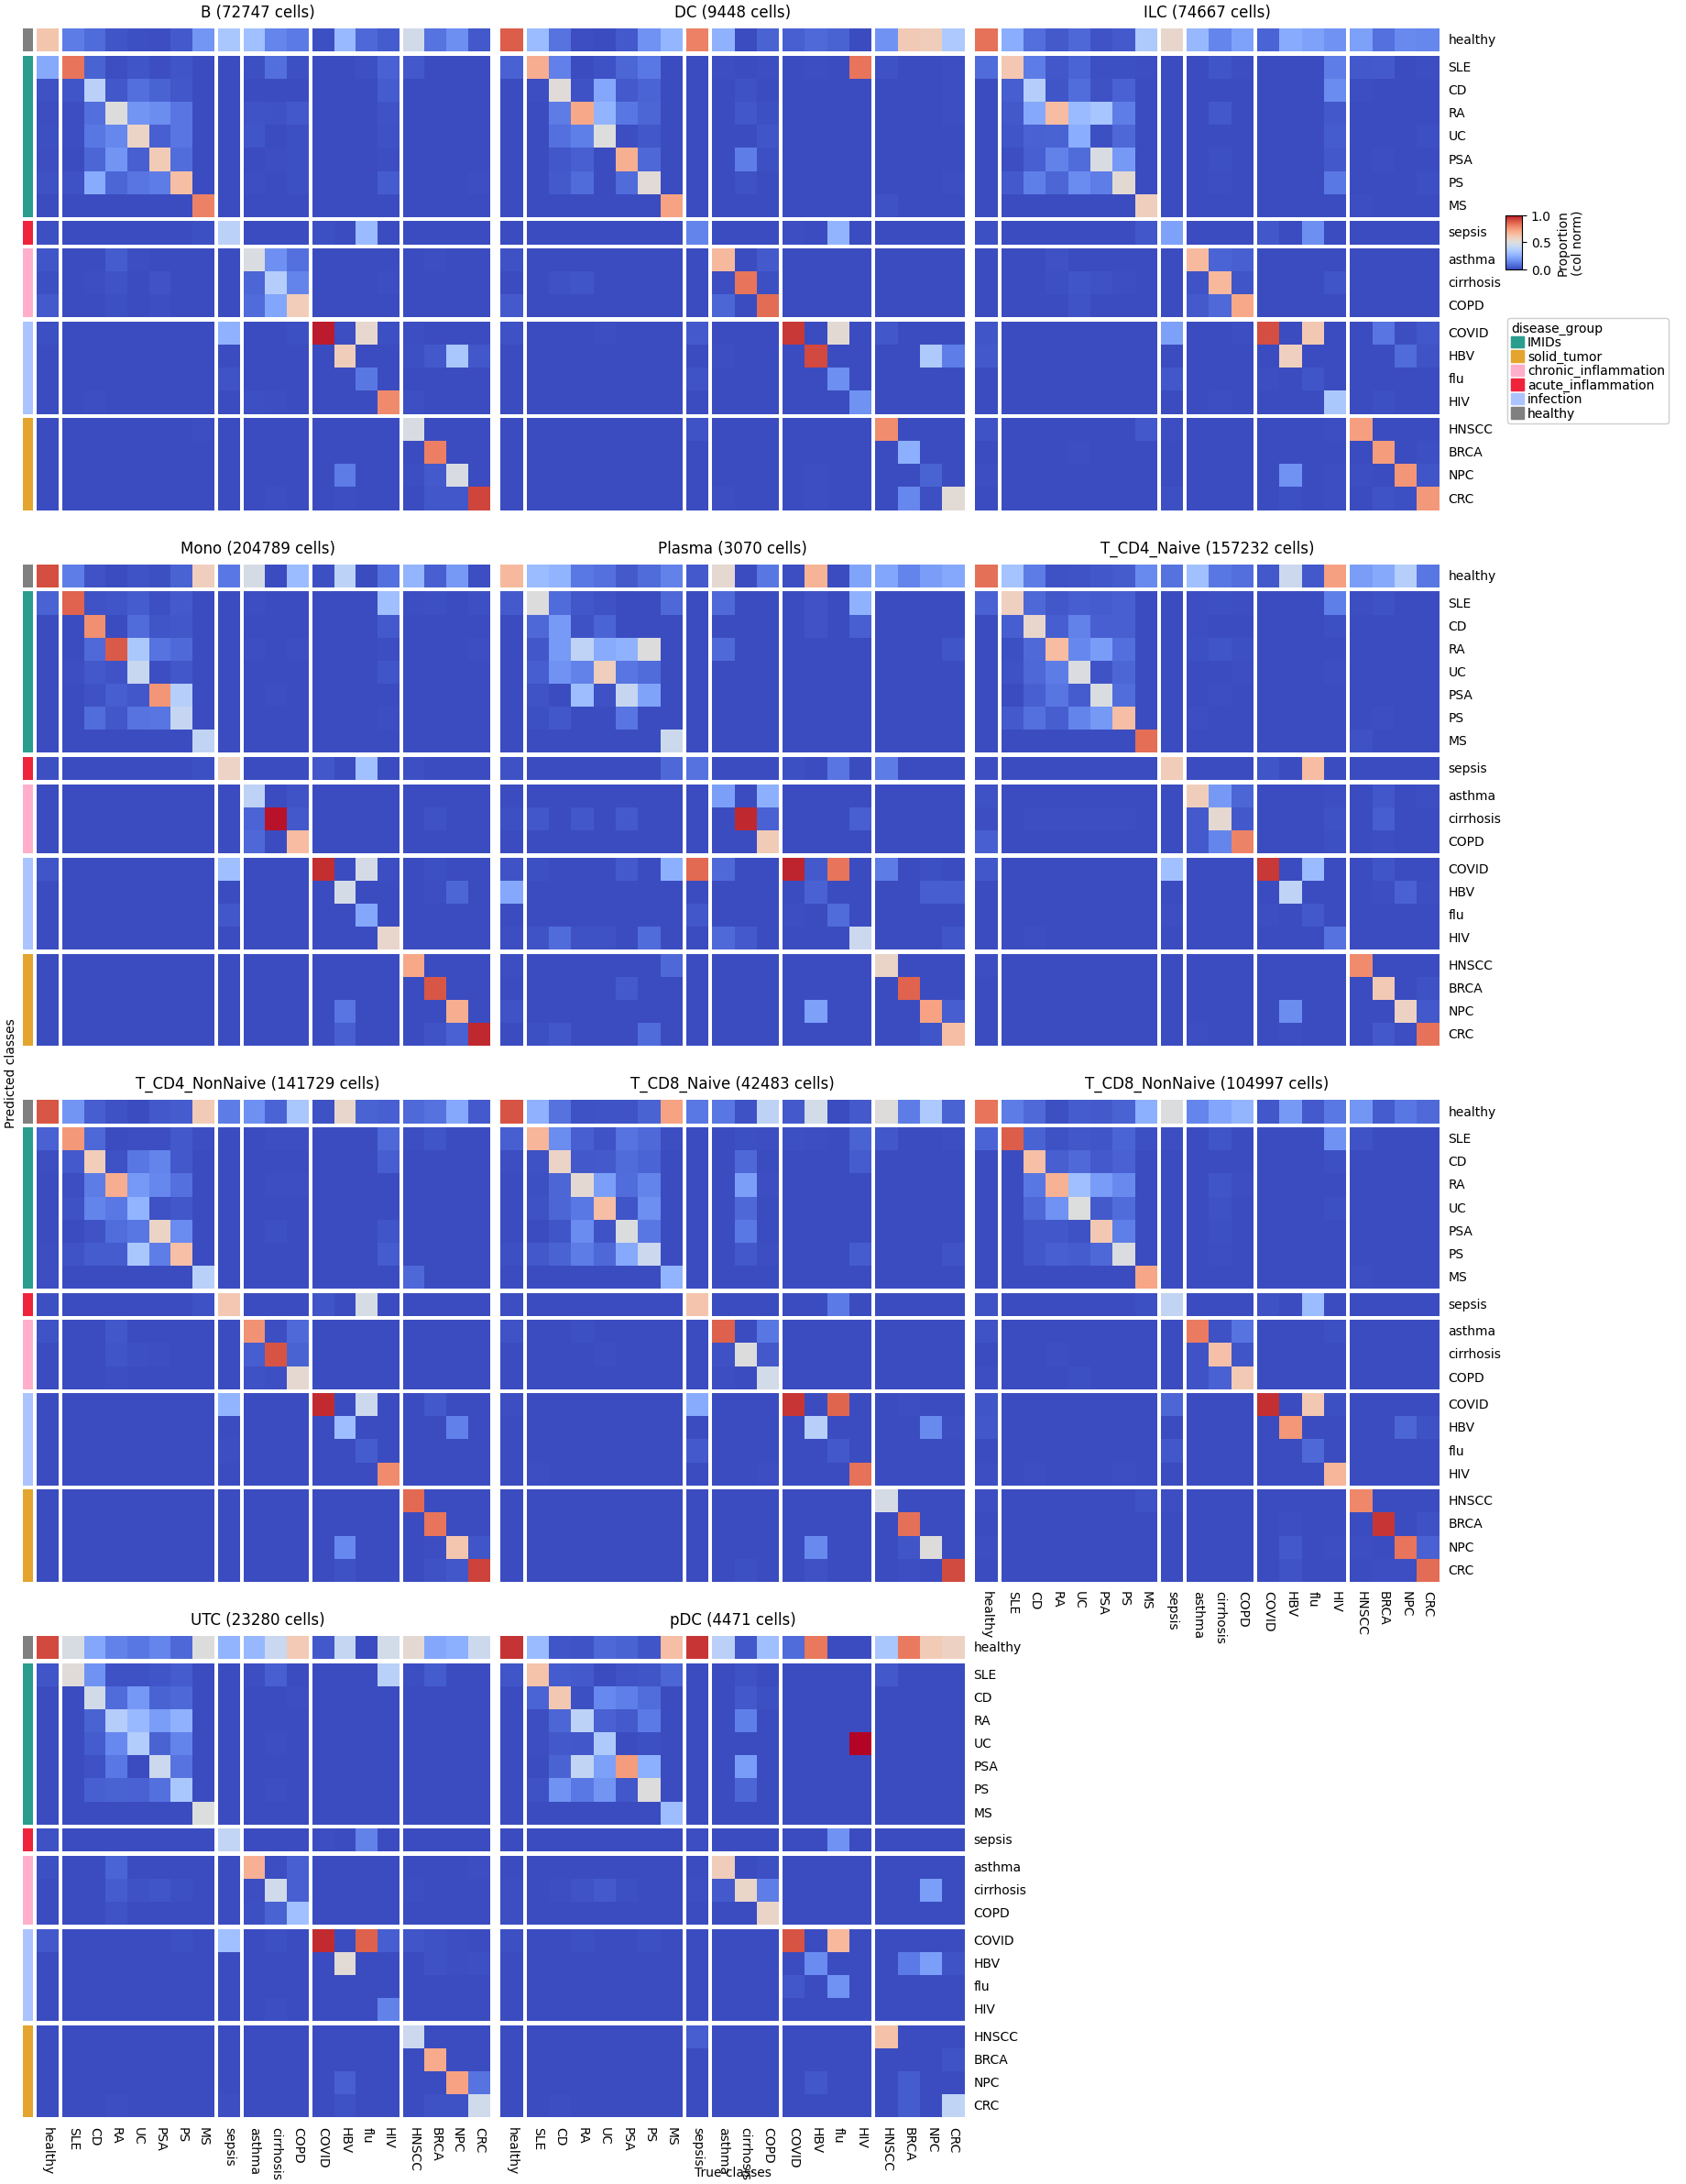

In [30]:
nCol = 4 #max(np.ceil((len(cellTypeList)+1) / 2).astype(int),1)
nRow = len(cellTypeList) // nCol + (len(cellTypeList) % nCol > 0)

wholeCM = list()
wholeCT = list()
confusionMatrixXct = dict()
for r in range(nRow):
    rowCM = list()
    rowCT = list()
    for c in range(nCol):

        idx = ((nCol*r) + c)

        if idx >= len(cellTypeList):
            continue
        
        ct_i = cellTypeList[idx]

        print(ct_i)
        
        idxCellType = unCorrData.Level1==ct_i
        confusionMatrix_i = getConfusionMatrix(predTestDF= unCorrData.loc[idxCellType,:],  predCol = 'disease_pred', gtCol = 'disease')
        confusionMatrix_i.fillna(0, inplace=True)
        confusionMatrix_i_ord = reorder_ConfMatrix(mask_entries(confusionMatrix_i, lowerThan = -1), elementList=elementList)

        totCell = np.sum(idxCellType)

        ################# Annotations

        ################# 

        showRownames = False
        if (c == (nCol-1)) | (((nCol*r) + c+1) >= len(cellTypeList)):
            showRownames = True

        showColnames = False
        if (r == (nRow-1)) | (((nCol*(r+1)) + c) >= len(cellTypeList)):
            showColnames = True

        leftAnnotation = None
        if (c == 0):
            leftAnnotation = row_ann

        confusionMatrixXct[ct_i] = confusionMatrix_i_ord
        cm_i = ClusterMapPlotter(data=confusionMatrix_i_ord, 
                                 left_annotation=leftAnnotation, 
                                 # top_annotation=col_ann, 
                                 row_split=rowAnnDF.disease_cat, row_split_order=diseaseCatOrd,
                                 col_split=rowAnnDF.disease_cat, col_split_order=diseaseCatOrd,
                                 show_rownames=showRownames,show_colnames=showColnames, 
                                 plot=False, fmt=None,
                                 row_cluster=False, col_cluster=False, standard_scale = None,
                                 row_dendrogram=False,col_dendrogram=False, verbose=False, cmap='coolwarm', rasterized=False, row_split_gap=1, col_split_gap=1,
                                legend=True, label = 'Proportion\n(col. norm.)',legend_anchor='ax_heatmap',legend_vpad=5,
                                vmax = 1, vmin = 0)            

        rowCM.append(cm_i)
        rowCT.append('{} ({} cells)'.format(ct_i, totCell))
    wholeCM.append(rowCM)
    wholeCT.append(rowCT)
            

print('Plotting ...')

mm2inch = 1 / 25.4

row_gap = 12
col_gap = 12

nR = len(wholeCM)
nC = len(wholeCM[0])

plt.figure(figsize=(25,18))

ax = plt.gca()

wspace = mm2inch * ax.figure.dpi / (ax.get_window_extent().width / nC)
hspace = row_gap * mm2inch * ax.figure.dpi / (ax.get_window_extent().height / nR)


gs = ax.figure.add_gridspec(
    nR,
    nC,
    width_ratios=[1 for i in range(nC)],
    height_ratios=[1 for i in range(nR)],
    wspace=wspace,
    hspace=hspace,
)

for r in range(nR):
    for c in range(nC):

        idx = ((nCol*r) + c)
        
        if idx >= len(cellTypeList):
            continue
        
        
        ax1 = ax.figure.add_subplot(gs[r,c], sharex=None, sharey=None)
        wholeCM[r][c].plot(ax =ax1, subplot_spec=gs[r,c])
        wholeCM[r][c].ax.set_title(wholeCT[r][c])

        

        if (r==0) and (c==0):
            label_max_width = ax.figure.get_window_extent().width * wholeCM[r][c].label_max_width / wholeCM[r][c].ax.figure.get_window_extent().width
            legend_list = wholeCM[r][c].legend_list
        
        ax1.set_axis_off()
        
space = col_gap * mm2inch * ax.figure.dpi + label_max_width + 15
plot_legend_list(legend_list, ax=ax, space=space, legend_side='right', gap=15, y0=0.8, legend_width=None)

ax.set_ylabel('Predicted classes')
ax.set_xlabel('True classes', labelpad = 35)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(here("03_downstream_analysis/08_gene_importance/results/confusionMatrix_cellTypes_NONcorrected.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [25]:
confusionMatrixXct

{'B': disease        healthy        CD        MS        PS       PSA        RA  \
 disease_pred                                                               
 healthy       0.621441  0.074125  0.176600  0.032183  0.006005  0.021662   
 CD            0.012144  0.380920  0.000000  0.027142  0.052656  0.025223   
 MS            0.002389  0.000000  0.805740  0.000000  0.000000  0.000000   
 PS            0.015379  0.234729  0.000000  0.645599  0.112240  0.060831   
 PSA           0.006868  0.061084  0.000000  0.075223  0.599538  0.173591   
 RA            0.006371  0.078929  0.000000  0.096161  0.153811  0.500890   
 SLE           0.233028  0.052162  0.000000  0.021714  0.004619  0.005935   
 UC            0.009009  0.100206  0.000000  0.095386  0.045266  0.140356   
 sepsis        0.010352  0.000000  0.008830  0.000000  0.000000  0.000000   
 COPD          0.033994  0.000686  0.000000  0.000000  0.005081  0.008605   
 asthma        0.020406  0.000686  0.000000  0.000388  0.000462  0.0379

In [26]:
# Session info
session_info.show()